In [2]:
from collections import defaultdict
from scipy.spatial.distance import squareform, pdist
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# custom seaborn plot options to make the figures pretty
sns.set(color_codes=True, style='white', context='notebook', font_scale=1.25)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Independence testing with partial distance correlation

In [3]:
from hyppo.independence import Dcorr

In [4]:
def simulate_2sample_null(n1, n2=None, d=100, group_std=0.1, seed=None):
    """
    Simulates a set of paired observations for a 2-sample test.
    
    n1,n2 : size of the two groups. Are both n1 if n2 is None
    d : dimension of observations
    group_std : standard deviation of normal distribution around group mean
    """
    np.random.seed(seed)
    
    # Means for each observation
    mus1 = np.random.normal(0,1,(n1,d))
    if n2 is not None:
        mus2 = np.random.normal(0,1,(n2,d))
    
    # Paired observations
    X = np.vstack(
        [np.random.normal(mu, group_std, (2,d)) for mu in mus1]  +
        [np.random.normal(mu, group_std, (2,d)) for mu in mus2]
    )        
    return X

In [13]:
# Simulation parameters
n1 = 25
n2 = 25
d = 100
group_std = 0.1

# Labels
Y_within = np.asarray([0, 1] * (n1 + n2))
Y_across = np.hstack(([0] * n1 * 2, [1] * n2 * 2))

# Permutation tree blocks
blocks_across = np.c_[
    np.hstack([[i+1]*2 for i in range(n1+n2)]),
    -1*Y_within - 1
]

# Permutation tree blocks
blocks_within = -1*np.hstack([[i+1]*2 for i in range(n1+n2)]).T
blocks_across = np.c_[
    np.hstack([[i+1]*2 for i in range(n1+n2)]),
    -1*Y_within - 1
]

# Pair labels, one hot encoded
pairs = np.hstack([[i+1]*2 for i in range(n1+n2)])
pairs = np.eye(len(set(pairs)))[pairs-1]

# Test params
pair_labels = [None, None, pairs, pairs][2:]
test_blocks = [None, None, blocks_within, blocks_across][2:]
test_names = ['Unrestricted within', 'Unrestricted across', 'Restricted within', 'Restricted across'][2:]
test_Ys = [Y_within, Y_across, Y_within, Y_across][2:]

In [14]:
N_DATASETS = 100
REPS = 250
test_results = defaultdict(list)

In [15]:
for i in range(N_DATASETS):
    X = simulate_2sample_null(n1, n2, d, group_std, seed=i)
    for test, pairs, blocks, Y in zip(test_names, pair_labels, test_blocks, test_Ys):
        _, pval = Dcorr().test(
            X,Y,pairs,
            reps=REPS,
            workers=-1,
            perm_blocks=blocks,
        )
        test_results[test].append(pval)

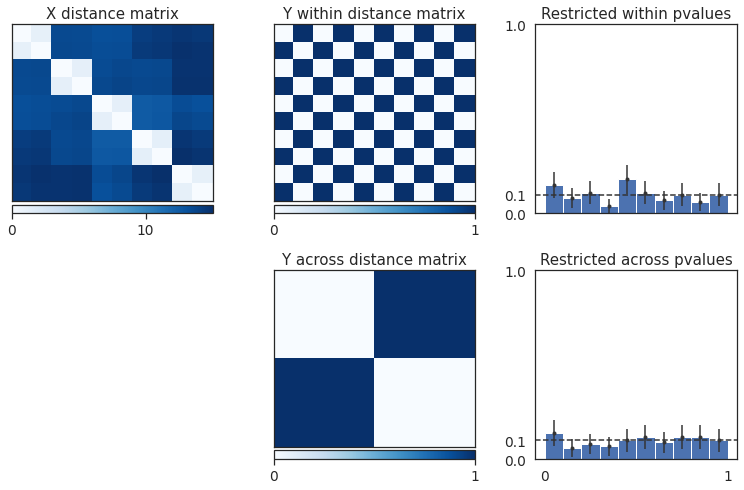

In [16]:
#fig, axes = plt.subplots(2,3, figsize=(4, 4*len(data_dict.keys())))
fig = plt.figure(figsize=(13, 8))

# Show data example
ax = fig.add_subplot(231)

X = simulate_2sample_null(n1, n2, d, group_std, seed=0)[:10,:]
X = squareform(pdist(X))
heatmap = ax.pcolor(X, cmap=plt.cm.Blues)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('X distance matrix')

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax, ticks=[0, 10], orientation='horizontal')

# Plot Y matrices
ax = fig.add_subplot(232)
heatmap = ax.pcolor(squareform(pdist(Y_within[:10, np.newaxis])), cmap=plt.cm.Blues)
#ax.colorbar(heatmap)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Y within distance matrix')

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax, ticks=[0, 1], orientation='horizontal')

ax = fig.add_subplot(235)
heatmap = ax.pcolor(squareform(pdist(np.hstack((Y_across[:5], Y_across[-5:]))[:, np.newaxis])), cmap=plt.cm.Blues)
#ax.colorbar(heatmap)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Y across distance matrix')

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax, ticks=[0, 1], orientation='horizontal')

# Plot pvalue histograms and errorbars using binomial CIs
ax = None
for i,test_name in zip([3,6], test_names):
    ax = fig.add_subplot(int(str(f'23{i}')))#, sharey=ax)
    n = len(test_results[test_name])
    entries, edges, _ = ax.hist(test_results[test_name], bins = np.arange(0,1.1,0.1), weights=np.ones(n)/n, color='b')
    # entries = height of each column = proportion in that bin
    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
    # errorbars are binomial proportion confidence intervals
    ax.errorbar(
        bin_centers, entries,
        yerr = 1.96 * np.sqrt(entries * (1 - entries) / n),
        fmt='.',c='#333333'
    )
    ax.set_title(f'{test_name} pvalues')
    #ax.set_xlim(0,1)
    if i in [3,4]:
        ax.set_xticks([])
    else:
        ax.set_xticks([0,1])
    if i in [4,8]:
        ax.set_yticks([0,0.1])
    else:
        ax.set_yticks([0, 0.1, 1])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()